# Comparative techno-economic analysis

Techno-economic analyses (TEAs) of emerging and conceptual technologies rarely provide a good estimate of economic viability. In fact, economic indicators are largely overly optimistic due to biased assumptions and unforeseen expenses. The real power of early-stage TEA is the ability to **compare** technologies under harmonized assumptions and establish key **performance targets** that technologies need to meet for market competitiveness. Performing comparative techno-economic analysis under harmonized assumptions, however, can be challenging due to the complexity of managing many biorefinery codes/files. In this chapter, we demonstrate how BioSTEAM can facilitate the evaluation and comparison of many configuration **scenarios** through ProcessModel objects.


## Process models

ProcessModel objects allow us to write code for many related configurations with ease. It streamlines the process of creating a model, including:

* Defining **scenarios** to compare.
* Creating the **thermodynamic property package**.
* Forming the **system** from unit operations.
* Setting up the evaluation **model**.

Additionally, all objects created within the process model (e.g., chemicals, streams, units, systems) can be easily accessed as attributes.

The first step is to inherit from the ProcessModel abstract class. An abstract class has missing (or "abstract") attributes/methods which the user must define to complete the class. The user must define a `Scenario` dataclass, and `as_scenario`, `create_thermo`, `create_system`, `create_model` methods for the process model to initialize its key components. 

It may help to look at how ProcessModel objects are created (approximately):
    
```python
def __new__(cls, simulate=None, scenario=None, **kwargs):
    if scenario is None:
        self.scenario = cls.Scenario(**kwargs)
    else:
        # The Scenario object can be initialized through the `as_scenario` class method.
        self.scenario = cls.as_scenario(scenario)
    
    # No need to recreate a process model for repeated scenarios.
    if scenario in cls.cache: return cls.cache[scenario]
    self = super().__new__()
    
    # The thermodynamic property package is given by the `create_thermo` method.
    self.load_thermo(self.create_thermo())
    
    # If no system is returned by the `create_system` method, a new system is created from flowsheet units.
    self.flowsheet = bst.Flowsheet()
    system = self.create_system()
    if system is None: system = self.flowsheet.create_system()
    
    # This saves the system as self.system and all units/streams as attributes by ID.
    # For example, Stream('feedstock') will be stored as self.feestock.
    self.load_system(system) 
    
    # A Model object is loaded from the `create_model` method.
    # The model will be stored as self.model and all parameters and indicators as attributes by function name.
    # For example: 
    #
    # @model.indicator
    # def MSP(): return self.tea.solve_price(self.product)
    #
    # ^ This becomes self.MSP.
    self.load_model(self.create_model())
    
    if simulate: self.system.simulate()
    self.cache[scenario] = self
    return self

```

## Cellulosic ethanol production

As a demonstrative case study, we will perform economic analysis of cellulosic ethanol production for two alternative biorefinery configurations: one processing corn stover with dilute acid pretreatment [1] and another processing switch grass with AFEX pretreatment [2]. For simplicity, assumptions on fermentation performance in the switch grass biorefinery are the same as in the corn stover biorefinery.

In [2]:
from biorefineries import cellulosic
from biorefineries.ethanol import create_ethanol_purification_system
from biorefineries.tea import create_cellulosic_ethanol_tea
import biosteam as bst
bst.nbtutorial()

class CellulosicEthanolBiorefinery(bst.ProcessModel):
    # The 'Scenario' class defines arguments to the process model.
    # It works very similar to a python dataclass: https://docs.python.org/3/library/dataclasses.html
    class Scenario:
        # To define an argument, you must include the type, but the default is optional.
        # You can also add metadata by tagging along a string that starts with #.
        feedstock: str = 'cornstover', '# dry at 20% moisture content'
        pretreatment: str = 'dilute acid'
    
    @classmethod
    def as_scenario(cls, scenario):
        # Interpret strings in the form of '{feedstock}/{pretreatment}' as a scenario.
        feedstock, pretreatment = scenario.split('/')
        return cls.Scenario(feedstock, pretreatment)
    
    def create_thermo(self):
        return cellulosic.create_cellulosic_ethanol_chemicals()
    
    def create_system(self):
        # Here we create the units and connect them.
        # BioSTEAM can take care of creating the system.
        cellulosic.load_process_settings()
        scenario = self.scenario # The input parameters to the process model are saved here.
        if self.scenario.feedstock == 'cornstover':
            feedstock = bst.Stream(
                ID='feedstock',
                price=0.0516,
                total_flow=104229.16,
                units='kg/hr',
                Water=0.20215,
                Sucrose=0.00623,
                Extract=0.11846,
                Acetate=0.01464,
                Ash=0.03986,
                Lignin=0.12744,
                Protein=0.02507,
                Glucan=0.28302,
                Xylan=0.15788,
                Arabinan=0.01925,
                Mannan=0.00485,
                Galactan=0.00116,
            )
        elif self.scenario.feedstock == 'switchgrass':
            feedstock = bst.Stream(
                ID='feedstock',
                total_flow=104229.16,
                price=0.08,
                units='kg/hr',
                Arabinan=0.02789,
                Galactan=0.01044,
                Glucan=0.2717,
                Xylan=0.21215,
                Mannan=0.00594,
                Lignin=0.17112,
                Ash=0.01619,
                Extract=0.0756,
                Acetate=0.00897,
                Water=0.2,
            )
        else:
            raise ValueError('invalid feedstock')
        
        ethanol = bst.Stream(ID='ethanol', price=0.5)
        U101 = cellulosic.units.FeedStockHandling('U101', feedstock)
        U101.cost_items['System'].cost = 0.
        
        if scenario.pretreatment == 'dilute acid':
            create_pretreatment_sys = cellulosic.create_dilute_acid_pretreatment_system
        elif scenario.pretreatment == 'AFEX':
            create_pretreatment_sys = cellulosic.create_ammonia_fiber_expansion_pretreatment_system
        else:
            raise ValueError('invalid pretreatment')
            
        pretreatment_sys = create_pretreatment_sys(
            ins=U101-0, area=200, mockup=True,
        )
        fermentation_sys = cellulosic.create_cellulosic_fermentation_system(
            ins=pretreatment_sys.get_outlet('pretreated_biomass'), area=300, mockup=True,
            # Valid arguments include:
            # Integrated Bioprocess (IB)
            # Simultaneous Saccharification and Co-Fermentation (SSCF)
            # Saccharification and Co-Fermentation (SCF)
            kind='IB',
        )
        ethanol_purification_sys = create_ethanol_purification_system(
            ins=fermentation_sys.get_outlet('beer'),
            outs=[ethanol], area=400, mockup=True,
        )
        ethanol, stillage, stripper_bottoms_product = ethanol_purification_sys.outs
        water = bst.Stream(Water=1, T=47+273.15, P=3.9*101325, units='kg/hr')
        S401 = bst.PressureFilter(400, (stillage, water))
        bst.create_all_facilities(
            # Certain facilities like the Fire Water Tank (in case there is a fire)
            # is sized based on feedstock flow rate
            feedstock,
            recycle_process_water_streams=[stripper_bottoms_product],
            HXN=False, # No heat exchanger network,
            area=600,
        )
    
    def create_model(self): # We create the Model object here.
        system = self.system # BioSTEAM automaticaly creates the system and saves it as self.system
        self.tea = tea = create_cellulosic_ethanol_tea(system)
        model = bst.Model(system)
        price = self.feedstock.price * 1000 # USD / MT
        processing_capacity = self.feedstock.F_mass * tea.operating_hours / 1e6 # 10^3 MT / y
        
        @model.parameter(
            element='feedstock', units='USD/kg', # Metadata for pretty tables/plots
            baseline=price, # Baseline price
            bounds=(price * 0.9, price * 1.1) # Min/max price
        )
        def set_feedstock_price(feedstock_price):
            self.feedstock.price = feedstock_price / 1000

        @model.parameter(
            element='feedstock', units='10^3 MT/y',
            baseline=processing_capacity,
            bounds=(processing_capacity * 0.9, processing_capacity * 1.1)
        )
        def set_processing_capacity(processing_capacity):
            self.feedstock.F_mass = 1e6 * processing_capacity /  tea.operating_hours 

        @model.indicator(units='USD/gal')
        def MESP():
            return tea.solve_price(self.ethanol) * 2.98668849 # USD/kg to USD/gal

        @model.indicator(units='10^6 USD')
        def TCI():
            return tea.TCI / 1e6
        
        return model


Let's create the cellulosic ethanol biorefinery and explore the process model attributes.

In [5]:
# Create the process model without simulating the system
cellulosic_br = CellulosicEthanolBiorefinery(simulate=False)
cellulosic_br

CellulosicEthanolBiorefinery(
    # dry at 20% moisture content
    feedstock='cornstover',
    pretreatment='dilute acid',
)


In [6]:
# Simulate and look at the diagram
cellulosic_br.system.simulate()
cellulosic_br.system.diagram('cluster')

In [7]:
# Access any unit operation or stream in the system
cellulosic_br.R301.results(basis='SI')

Saccharification and co fermentation              Units      R301
Electricity         Power                            kW   1.3e+03
                    Cost                         USD/hr      74.1
Chilled water       Duty                          kJ/hr -4.27e+07
                    Flow                        kmol/hr  2.86e+04
                    Cost                         USD/hr         0
Design              Flow rate                      m³/s   0.00917
                    Reactor volume                   m³     4e+03
                    Batch time                                109
                    Loading time                             9.09
                    Batch duty                 kg·m²/s³ -6.49e+06
                    Reactor duty               kg·m²/s³ -5.36e+06
Purchase cost       Reactors (x12)                  USD  1.05e+07
                    Agitators (x12)                 USD  6.52e+05
                    Fermentor batch cooler          USD  9.45e+04
                    Heat exchangers (x12)           USD  2.73e+05
                    Recirculation pumps (x12)       USD  2.89e+05
Total purchase cost                                 USD  1.18e+07
Utility cost                                     USD/hr      74.1

In [8]:
# Access the model
cellulosic_br.model

Model:
parameters: Feedstock - Feedstock price [USD/kg]
            Feedstock - Processing capacity [10^3 MT/y]
indicators: MESP [USD/gal]
            TCI [10^6 USD]


In [9]:
# Access model parameters and indicators
cellulosic_br.set_feedstock_price(0.06)
cellulosic_br.MESP()

1.2948598519220182

Note how all streams, units, systems, parameters and indicators can be easily accessed. Let's now use the process model to conduct a simple uncertainty analysis on the impact of feedstock price and flow rate on the minimum ethanol selling price for each configuration:

Text(0, 0.5, 'MESP [USD/gal]')

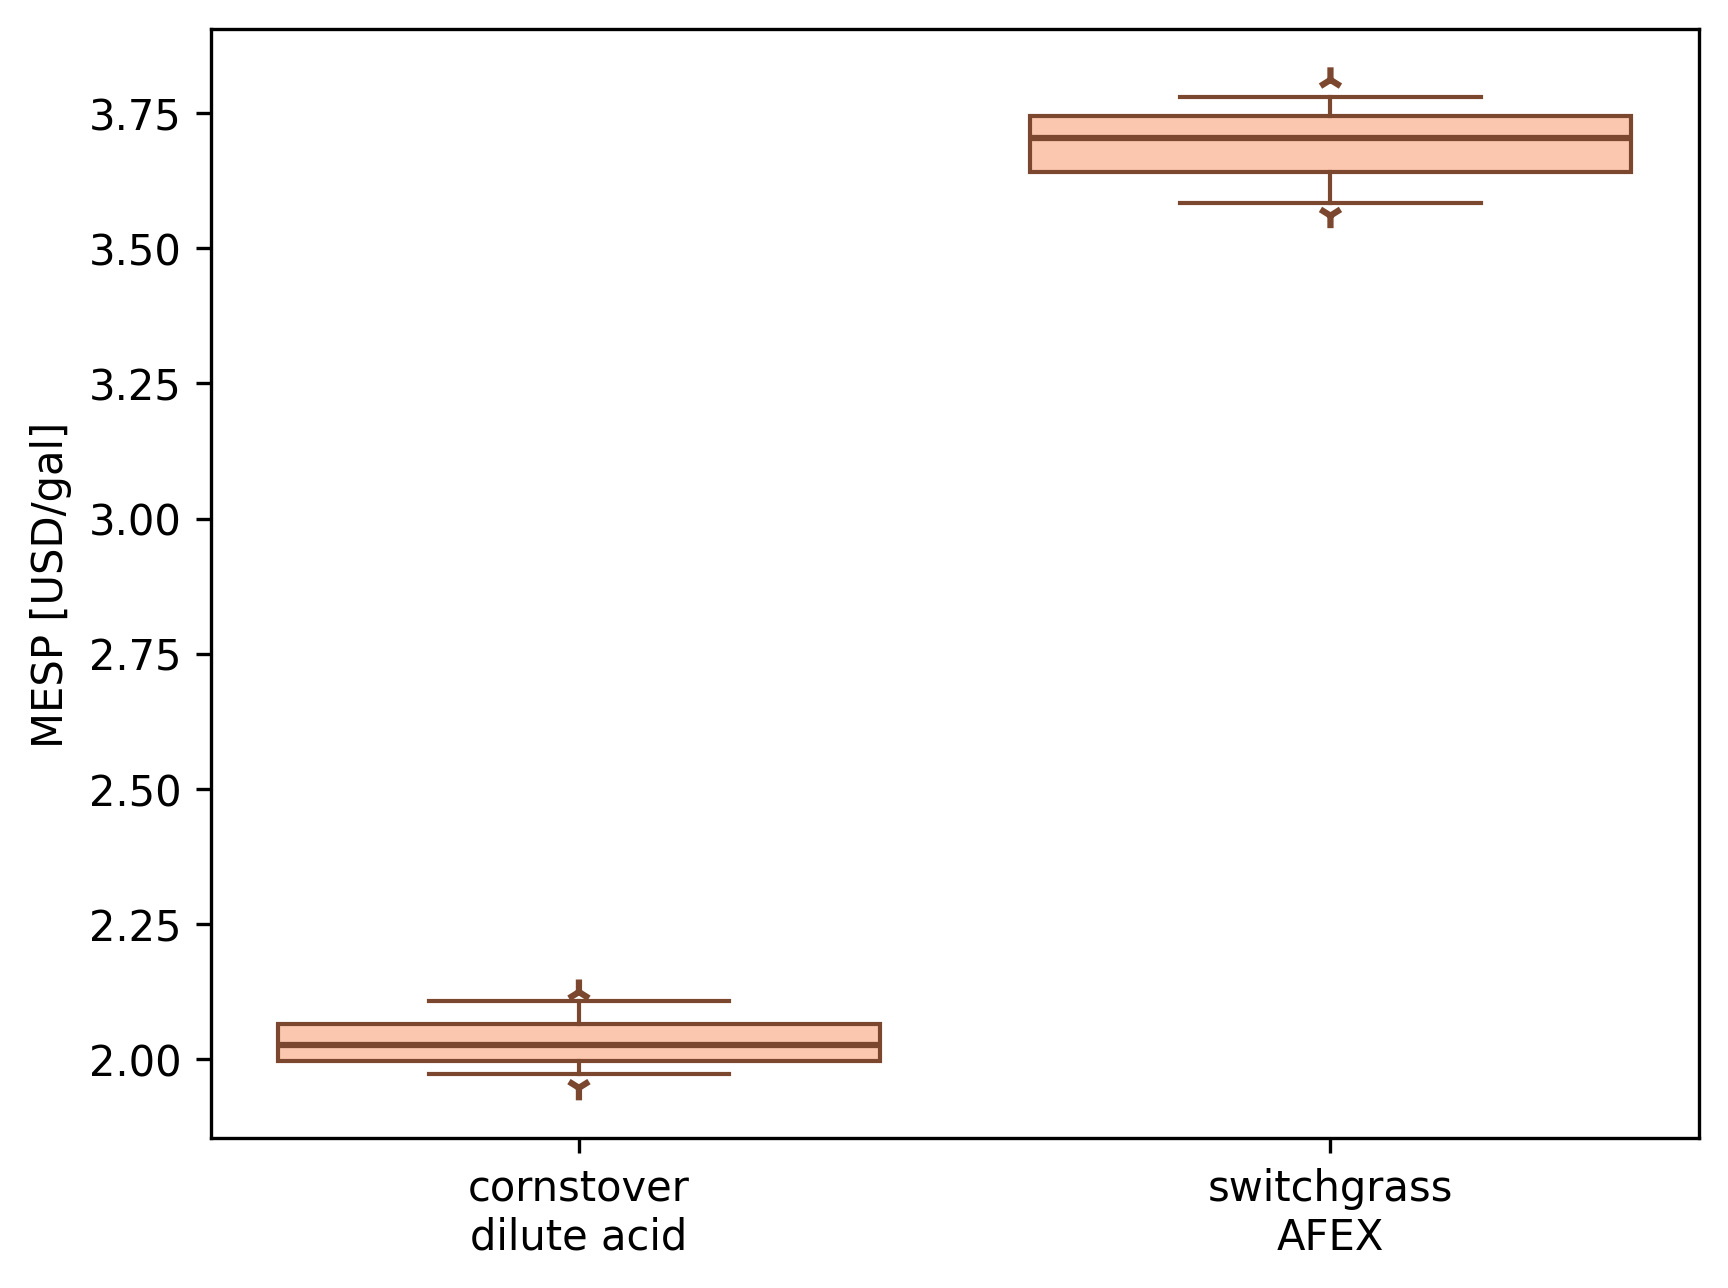

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from biosteam.plots import plot_montecarlo

scenarios = ['cornstover/dilute acid', 'switchgrass/AFEX']
biorefineries = []
data = []
for scenario in scenarios:
    br = CellulosicEthanolBiorefinery(scenario=scenario, simulate=False)
    samples = br.model.sample(50, 'L')
    br.model.load_samples(samples, sort=True)
    br.model.evaluate()
    biorefineries.append(br)
    data.append(br.model.table[br.MESP.index])

dct = plot_montecarlo(data=np.array(data), xmarks=[i.replace('/', '\n') for i in scenarios])
plt.ylabel(br.MESP.describe())

Using the ProcessModel objects, we were quickly able to define the biorefinery models and configurations and conduct uncertainty and sensitivity analyses. Biorefineries in the [Bioindustrial-Park](https://github.com/BioSTEAMDevelopmentGroup/Bioindustrial-Park) repository leverage ProcessModel objects in this way too.

While this dumbed-down uncertainty analysis suggests that one configuration is much more economically viable than the other,  the assumptions behind the analysis are arbitrary and a more rigorous uncertainty analyses would base all assumptions on expert knowledge. 

### References

<a id='References'></a>

1. Humbird, D. et al. Process design and economics for biochemical conversion of lignocellulosic biomass to ethanol: Dilute-acid pretreatment and enzymatic hydrolysis of corn stover. http://www.nrel.gov/docs/fy11osti/47764.pdf (2011).

2. Serate, J. et al. Controlling microbial contamination during hydrolysis of AFEX-pretreated corn stover and switchgrass: effects on hydrolysate composition, microbial response and fermentation. Biotechnol Biofuels 8, 180 (2015).
